# Прогнозирование оттока клиентов фитнес центра. ML

**Описание проекта**

Сеть фитнес-центров «Культурист-датасаентист» хочет спрогнозировать отток клиенов и разработать план по удержанию их. Необходимо спроектировать модель, которая будет придсказывать вероятность оттока каждого клиента. Выделить признаки, наиболее сильно влияющие на отток. Сформировать группы клиентов, и повысить качество работы с ними.

**Описание данных**

Данные клиента за предыдущий до проверки факта оттока месяц
* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
* `Сontract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* `Churn` — факт оттока в текущем месяце.

**План работы**
- Прочитаем полученые данные.
- Проведем предобработку данных (EDA).
 - проверим отсутствие данных
 - изучим среднее значения и стандартное отклонение
 - изучим распределение признаков
 - построим матрицу корреляции
- Построим модель бинарной классификации клиентов.
 используем два способа обучения
 - логистической регрессией
 - случайным лесом
- Кластеризуем клиентов.
- Разработаем стратегию по работе с клиентами.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загружаем-данные" data-toc-modified-id="Загружаем-данные-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загружаем данные</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Построение-модели-прогнозирования-оттока-клиентов" data-toc-modified-id="Построение-модели-прогнозирования-оттока-клиентов-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение модели прогнозирования оттока клиентов</a></span></li><li><span><a href="#Кластеризация-клиентов" data-toc-modified-id="Кластеризация-клиентов-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Кластеризация клиентов</a></span></li><li><span><a href="#Рекомендации-по-работе-с-клиентами" data-toc-modified-id="Рекомендации-по-работе-с-клиентами-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Рекомендации по работе с клиентами</a></span></li></ul></div>

## Загружаем данные

In [1]:
# импортируем бибилиотеки
import pandas as pd
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
# чтение данных
fits = pd.read_csv('gym_churn.csv')

In [4]:
# узнаем размер датасета
fits.shape

(4000, 14)

In [5]:
# посмотрим на данные в таблице
fits.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
# посмотрим на сводную информацию о наборе данных
fits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [7]:
# приведем к нижнему регистру названия столбцов
fits.columns = fits.columns.str.lower()

In [8]:
# проверим на дубликаты
fits.duplicated().sum()

0

In [9]:
# посмотрим, как соотносятся классы для нашего набора данных
fits['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

**Вывод** В датасете 4000 строк и 14 колонок из них 13 признаков и 1 целевая переменная. Большая часть признаков категориальные двух классов, остальные числовые. В данном датасете целевая переменая не имеет временную структуру. В датасете нет пропусков, все признаки заполнены. Целевая переменная соотносится как 1:3 или 25% оттока и 75% не оттока. 

## Исследовательский анализ данных

In [10]:
# описательная статистика
fits.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [11]:
# сгруппируем данные по целевой переменной (отток) и посчитаем среднии значения всех признаков
fits.groupby(['churn']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


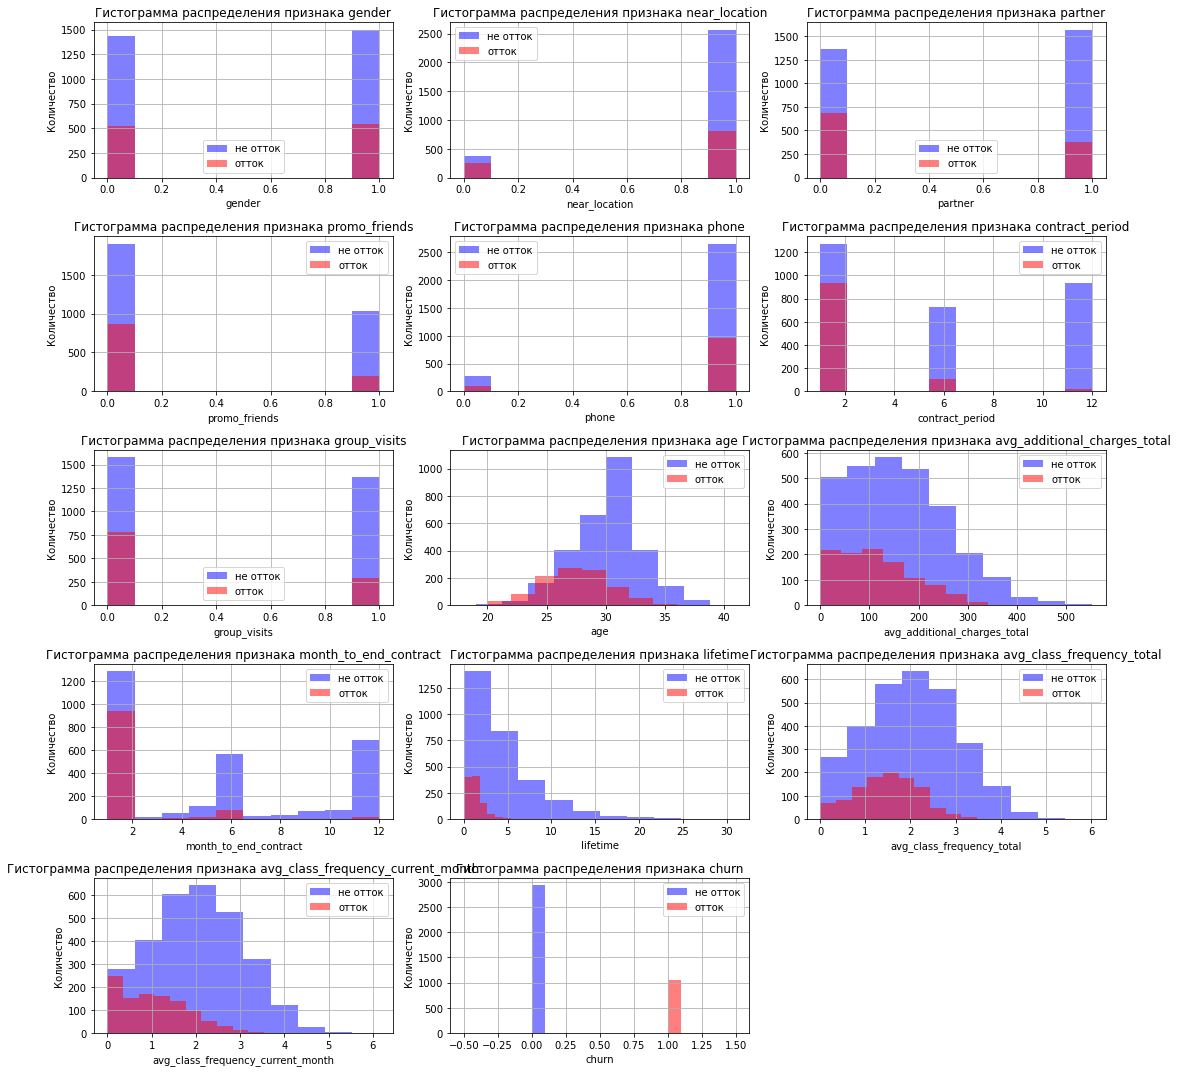

In [12]:
# гристограммы распределения признаков с делением по целевой переменной
plt.figure(figsize=(15, 15))
for i, feature in enumerate(fits.columns):
    plt.subplot(5, 3, i+1)
    axes = fits.query('churn == 0')[feature].hist(bins=10, alpha=0.5, label='не отток', color='b')
    fits.query('churn == 1')[feature].hist(ax=axes, bins=10, alpha=0.5, label='отток', color='r')
     
    plt.title(f'Гистограмма распределения признака {feature}')
    plt.xlabel(f'{feature}')
    plt.ylabel('Количество')
    plt.legend()
    
     
plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
plt.show()  

Из графиков видно различия в распределениях признаков ушедших клиентов и оставшихся. Например, разница хорошо видна на признаке "near_location", среди тех, кто не живет в районе, где находиться фитнес-центр, большая доля оттока. Так же хорошо видна разница на признаке "month_to_end_contract", большая доля оттока среди тех, кто берет абонимент сроком на один месяц.

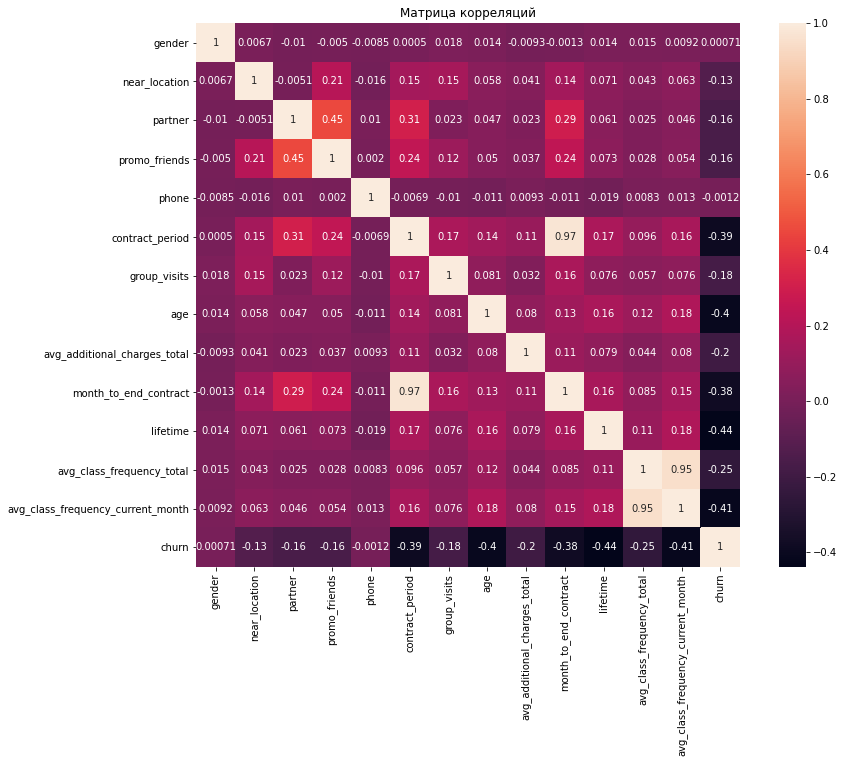

In [13]:
# построим матрицу корреляции
cm = fits.corr()

plt.figure(figsize = (14,10))
sns.heatmap(cm, square = True, annot = True) # нарисуем heatmap
plt.title('Матрица корреляций') 
plt.show()

**Вывод** При рассмотрении общей статистики датасета можно заметить, что некоторые признаки распределены нормально, например клиенты разбиты по половому признаку поровну, а некоторые признаик смещены в одну из сторон. Графики гристограмм с разбивкой по целевой переменной показывают это наглядно. В каких то признаках есть выбросы, например факт посещение групповых занятий очень высок среди клиентов, которые остаются привержены клубу. По матрице кореляции видно, что в датасете коррелируют две пары признаков: срок контракта и время до оконцания контракта, средняя частота посещений в неделю и средняя частота посещенийв месяц. Эти признаки взаимосвязаны и будут влиять друг на друга при обучении модели. Для рассмотрения всех возможных случаев в обучении моделей необходимо будет провести эксперементы с удалением коррелирующих признаков из датасета.

## Построение модели прогнозирования оттока клиентов

Проведем обучение моделей на полных данных.

In [14]:
# разделите наши данные на признаки (матрица X) и целевую переменную (y)
X = fits.drop('churn', axis=1)
y = fits['churn']

In [15]:
# разделите модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# стандартизируем данные 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
# создадим список с моделями
models = [
        LogisticRegression(solver='liblinear', random_state=0), 
        RandomForestClassifier(random_state=0)
]

In [18]:
# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))



In [19]:
# напишите цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train_st,
        y_train=y_train,
        X_test=X_test_st,
        y_test=y_test,
    )

LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
RandomForestClassifier(random_state=0)
Accuracy: 0.92
Precision: 0.84
Recall: 0.81


Получили значения метрик, по ним видно, что модель логистической регрессии имеет лучшие показатели. Проведем наши эксперементы по борьбе с мультиколлинеарностью. Удалим по очередно из датасета колеррирующие призначи и обучим модели с получением метрик для оценки качества модели.

In [20]:
# функция для проведения экспериментов
def experiment(df, tar, sing, models):
    X = df.drop([tar, sing], axis=1)
    y = df[tar]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_st = scaler.transform(X_train)
    X_test_st = scaler.transform(X_test)
    print(f'удаляемый признак: {sing}')
    for i in models:
        print(f'модель: {i}')
        make_prediction(
            m=i,
            X_train=X_train_st,
            y_train=y_train,
            X_test=X_test_st,
            y_test=y_test,
        )


In [21]:
experiment(fits, tar='churn', sing='contract_period', models=models)  

удаляемый признак: contract_period
модель: LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
модель: RandomForestClassifier(random_state=0)
Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Метрики модели логистической регрессии дали лучшие показатели с удаленым признаком - длительность контракта. Показатели модели случайный лес не изменились, только метрика полноты чуть подросла.

In [22]:
experiment(fits, tar='churn', sing='month_to_end_contract', models=models) 

удаляемый признак: month_to_end_contract
модель: LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.92
Precision: 0.85
Recall: 0.83
модель: RandomForestClassifier(random_state=0)
Accuracy: 0.91
Precision: 0.83
Recall: 0.81


В этом эксперементе показатели метрик у обоих моделей показывают себя хуже по сравнению с прошлым экспериментом и почти не отличаются от главных метрик полного датасета.

In [23]:
experiment(fits, tar='churn', sing='avg_class_frequency_total', models=models) 

удаляемый признак: avg_class_frequency_total
модель: LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.90
Precision: 0.79
Recall: 0.83
модель: RandomForestClassifier(random_state=0)
Accuracy: 0.89
Precision: 0.81
Recall: 0.75


Этот эксперимент показал наихудшие значения метрик для обоих моделей. Удаление признака - частота посещений в неделю - не дал улучшения моделей, вернем его обратно в датасет.

In [24]:
experiment(fits, tar='churn', sing='avg_class_frequency_current_month', models=models) 

удаляемый признак: avg_class_frequency_current_month
модель: LogisticRegression(random_state=0, solver='liblinear')
Accuracy: 0.90
Precision: 0.78
Recall: 0.81
модель: RandomForestClassifier(random_state=0)
Accuracy: 0.89
Precision: 0.80
Recall: 0.76


И здесь модели не улучшили свои показатели метрик, также удаление этого признака не дало ожидаемого улучшения моделей, нет смысла его удалять из датасета.

**Вывод** По итогам проведеных экспериментов лучшие значения метрик мы получили при удалении признакак - срок контракта, приэтом у модели логистической регрессии самые наилучшие значения метрик: доли привильных ответов, точности и полноты.

## Кластеризация клиентов

In [25]:
# стантартизация датасета
sc = StandardScaler()
X_sc = sc.fit_transform(fits)

In [26]:
# матрица расстояний
linked = linkage(X_sc, method = 'ward')

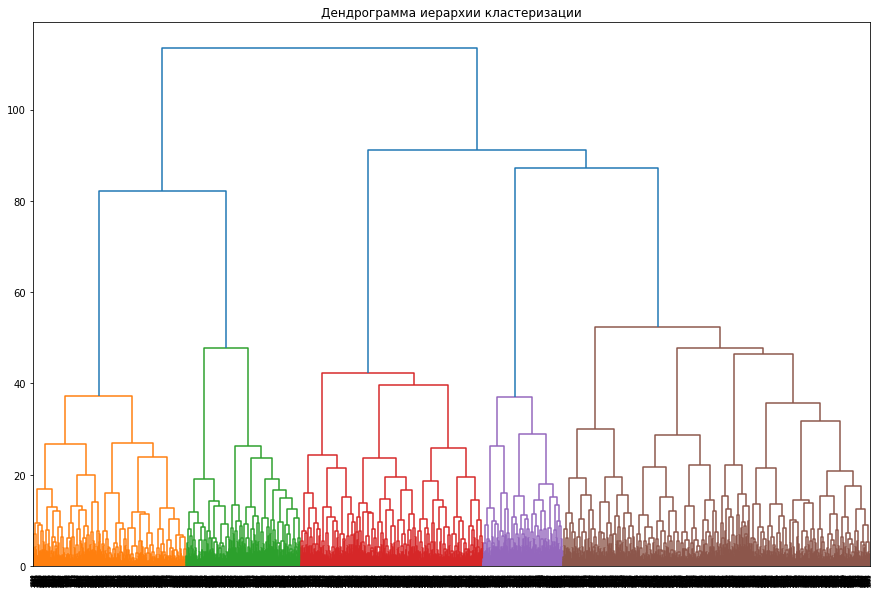

In [27]:
# рисуем дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма иерархии кластеризации')
plt.show()

На основании полученого графика можно выделить 5 кластеров, по количеству выделеных цветов.

In [28]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

In [29]:
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

In [30]:
# сохраняем метки кластера в поле нашего датасета
fits['cluster_km'] = labels

In [31]:
# среднии занчения признаков по кластерам
fits.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster_km,,,,,,,,,,,,,,
0,0.503676,0.000000,0.459559,0.075368,0.917279,2.069853,0.211397,28.522059,132.741216,1.950368,2.757353,1.706629,1.515890,0.450368
1,0.492829,0.936115,0.764016,0.534550,0.919166,10.447197,0.516297,29.962190,161.853561,9.477184,4.833116,2.788103,2.786919,0.007823
2,0.507917,1.000000,0.323995,0.213155,0.903776,1.546894,0.287454,26.926918,113.173051,1.500609,1.031669,1.449720,1.037592,0.961023
3,0.521186,0.996610,0.282203,0.208475,0.904237,1.882203,0.452542,30.237288,157.988625,1.794915,4.923729,2.203432,2.207359,0.003390
4,0.518895,0.968023,0.744186,0.526163,0.873547,8.859012,0.534884,29.728198,162.907495,8.155523,4.411337,0.957744,0.943967,0.024709


In [32]:
# посчитаем наполненость кластеров
fits.groupby(['cluster_km'])['age'].count()

cluster_km
0     544
1     767
2     821
3    1180
4     688
Name: age, dtype: int64

Больше всего клиентов в 3 кластере, и это самые "старые" клиенты, дольше всех ходят в фитнес клуб. Очень сильно выделяется группа клиентов под номером 0, в этой группе по большинству признакам низкие показатели и около половины оттока. Группа под номером 2 почти с 100% оттоком, но и клиентов в ней по количеству на втором месте по значениям, это случайные люди, которых случайно занесло в фитнес центр, начать новую жизнь у эти людей не получилось, хоть они и живуют рядом с центром, но абонимент был преобретен в среднем на 1 месец, и посетили финтес центр около 1 раза за весь период. Наверно, не стоит оставлять их без внимания и постараться найти к таким клиентам подход. Также стоит поработать над клиентами из 0 и 4 групп. Так же среди ушедящих преобладает тенденция, не посещать групповые занятия и мало преобретать дополнительных услуг фитнес центра.

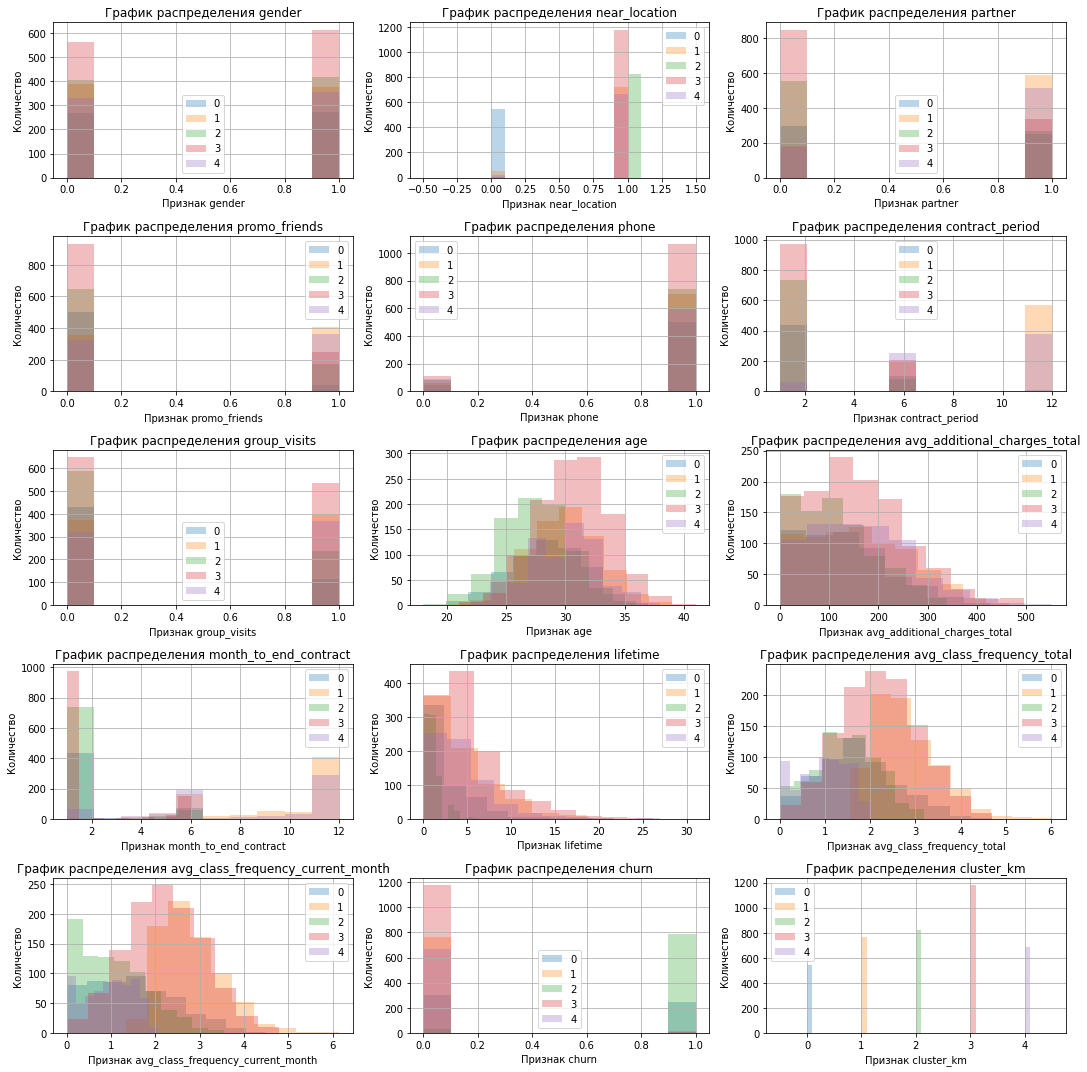

In [33]:
# распределение признаков для кластеров
plt.figure(figsize=(15, 15))
for i, feature in enumerate(fits.columns):
    plt.subplot(5, 3, i+1)
    fits.groupby(['cluster_km'])[feature].hist(bins=10, alpha=0.3, legend=True)
    plt.title(f'График распределения {feature}')
    plt.xlabel(f'Признак {feature}')
    plt.ylabel('Количество')
    plt.legend()
    
plt.tight_layout()  
plt.show()

Для большей наглядности построим еще нескольво видов графиков. Для категориальных признаков построим графики countplot.

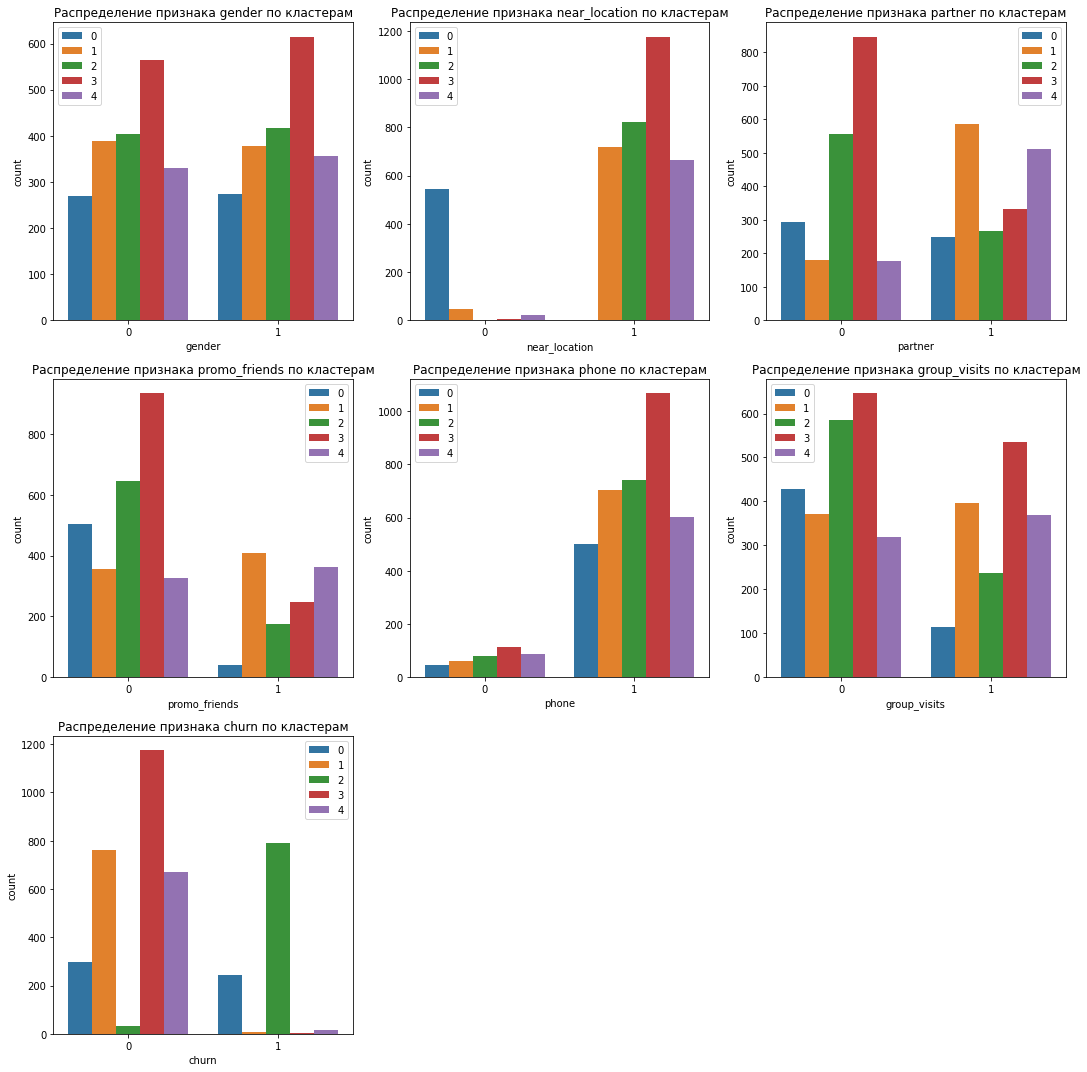

In [34]:
categorical = [
    'gender',
    'near_location',
    'partner',
    'promo_friends',
    'phone',
    'group_visits',
    'churn'
]

plt.figure(figsize=(15,15))
for i, feature in enumerate(categorical):
    axes = plt.subplot(3, 3, i+1)
    axes = sns.countplot(x=fits[feature], hue='cluster_km', data=fits)
    plt.title(f'Распределение признака {feature} по кластерам')
    plt.legend()

plt.tight_layout()  
plt.show()    

Для числовых признаков построим kdeplot.

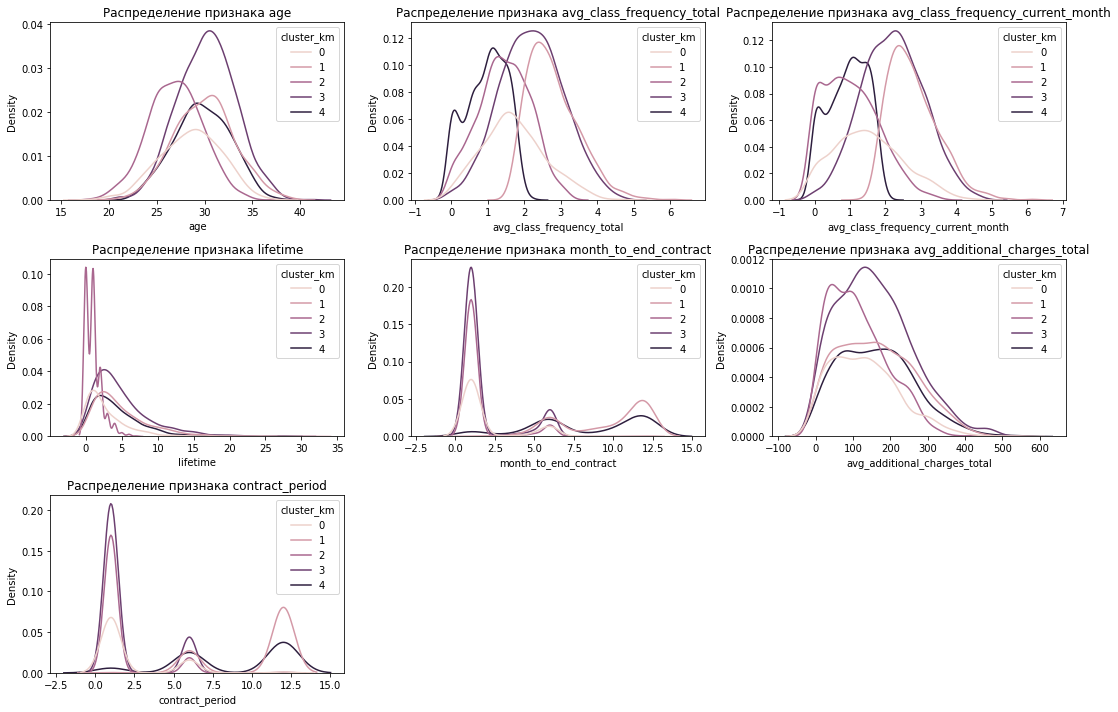

In [35]:
int = [
    'age',
    'avg_class_frequency_total',
    'avg_class_frequency_current_month',
    'lifetime',
    'month_to_end_contract',
    'avg_additional_charges_total',
    'contract_period'
]


plt.figure(figsize=(15,10))
for i, feature in enumerate(int):
    plt.subplot(3, 3, i+1)
    sns.kdeplot(x=fits[feature], hue='cluster_km', data=fits, legend=True)
    plt.title(f'Распределение признака {feature}')
    

plt.tight_layout()
plt.show()    

Модель выделила 5 групп клиентов. По графикам можно определить, что во всех группах мужчин и женчин поравну.
- кластер 0: 
В этом кластере клиенты живут в другой локации, отдаленной от центра. Отток среди них около половины, абонементы покупают в среднем на месяц, большая часть из них не ходит на групповые занятия, и они не давно пришли в клуб, не тратят средства на дополнительные улоуги фитнес центра.

- кластер 1:


- кластер 2:
Самый большой отток клиентов в этом кластере. Эти клиенты живут рядом, самые молодые, большая часть из них не ходит на групповые занятия, не пользуется дополнительными услугами клуба, и это не давно пришедшие клиенты, они редко ходят, и приобретают абонимент в среднем на 1 месяц.

- кластер 3:


- кластер 4:
Среди них есть не большая доля ушедших, большая часть из них это сотрудники компании-партнера клуба, из этой группы посещают клуб не часто,но берут длительные абонемнты, не тратятся на дополнительные услуга клуба. 

In [36]:
# считаем долю оттока для каждого кластера
round((fits.groupby(['cluster_km'])['churn'].mean()*100), 2)

cluster_km
0    45.04
1     0.78
2    96.10
3     0.34
4     2.47
Name: churn, dtype: float64

Можно выделить два кластера 0 и 2, где самая большая доля оттока клиентов.

In [37]:
# посчитаем метрику силуэта для нашей кластеризации

silhouette_score(X_sc, labels)

0.1346805783296413

Метрика оказалось не очень высокой, кластеризацию нельза назвать достаточно качественной. 

**Вывод** Хоть у кластеризации и не высокое качество модели, все таки были обнаружены интересные взаимосвязи в поведении клиентов и в факте их оттока. Среди тех кто покинул фитнес центр заметна тенденция не посещать групповые занятия, не пользоваться дополнительными услугам фитнес центра. Из двух обученых моделей, лучше всего себя показала модель логистической регресии с поправкой на мультиколлинеарность, признак - длительность абонимента - дублирующий признак с коэффициентом кореляции 0.97.

## Рекомендации по работе с клиентами

Рекомендации для стратегии взаимодействия с клиентами и их удержания:

1. Разработать новые виды групповых занятий
Мини группы с тренером по работе с тренажорами. Так же реализовать возможность по проведению командных игр: мини-футбол, баскетбол, волейбол. Открыть новые не стандартные занятия, например акробатика, воздушная гимнатика на полотнах.

2. Заинтересовать клиентов новыми видами услуг и товаров
Больше выбор спортивного питания, фитнес одежды, поезных девайсов, дополнительных улгуг: солярий, услуги парихмахера, диетолога, нуртициолога, маникюр.

3. Для тех кто начил новую жизнь с понедельника, но быстро потерял мотивацию, можно предложить акцию групповая работа с тренером и диетологом.

4. Повысить душевность атмосферы в клубе, качество сервиса.

Клиенты из кластера 0 перестают ходить из-за того что далеко находятся, с ними мы, наверное, ничего не сделаем, а клиенты из кластера 2 молодые, плохо ходят на групповые занятия, можно им предложить скидку на следующие месяцы или на групповые занятия.

Их надо как-то приобщить к коллективу и ответственности. Клиенты молодые, надо их заинтересовать новыми не стандартными тренировками и видами спорта. Так же они не тратятся на дополнительные услуги клуба, возможно они не нашли для себя подходящей услуги, можно расширить список услуг. Придумать систему поощерений, например -  ты пришел на тренировку получи бонус, купил следующий абонемент - дополнительная улуга со скидкой. Надо как то замотивировать людей заниматься фитнесом, возможно, те люди, которые ушли не смогли решить задачу, с которой они приходили в клуб.